In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import tifffile
from shapely.geometry import Polygon, box


In [39]:
ddir = 'G:\\Alexis_data\\Project\\SpatialOmics_cellpose\\results'
base_path = "G:\Alexis_data\Project\SpatialOmics_cellpose\data\output-XETG00245__0034188__1792od__20240613__195055"
fullres_chanel_0 = f"{base_path}\morphology_focus\morphology_focus_0000.ome.tif"
fullres_chanel_2 = f"{base_path}\morphology_focus\morphology_focus_0002.ome.tif"
sample_name = "1792od"

# Output directory
odir = f'{ddir}cellpose/'
gjurl = f'{odir}a.geojson'

# Levels: pixelsize in µm https://kb.10xgenomics.com/hc/en-us/articles/11636252598925
scalefactors = {
    0: 0.2125,
    1: 0.4250,
    2: 0.85,
    3: 1.7,
    4: 3.4,
    5: 6.8,
    6: 13.6,
    7: 27.2,
}


In [40]:
crop_size = 600/0.2125

In [ ]:

ROI_filepath = f"{base_path}\{sample_name}_corneasection.csv"

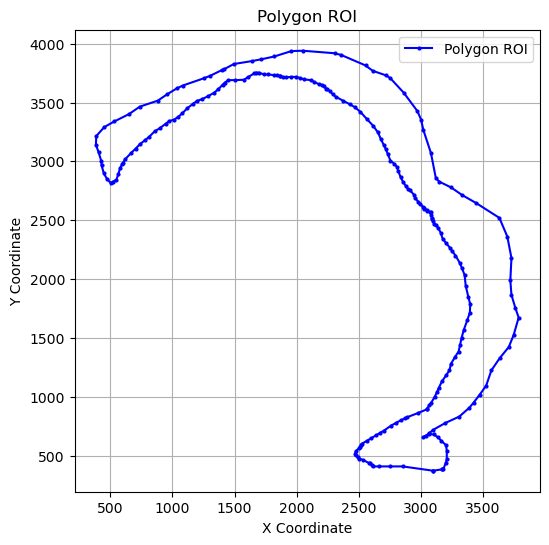

In [42]:
# Read the ROI coordinates from the CSV file
polygon_coords = pd.read_csv(ROI_filepath)

# Extract the X and Y coordinates
x_coords = polygon_coords['X']
y_coords = polygon_coords['Y']


# Create a plot
plt.figure(figsize=(6, 6))
plt.plot(x_coords, y_coords, marker='o', linestyle='-', color='b', label='Polygon ROI', markersize=2)

# Close the polygon by connecting the last point to the first
plt.plot([x_coords.iloc[0], x_coords.iloc[-1]], [y_coords.iloc[0], y_coords.iloc[-1]], 'b-')

# Adding labels and title
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title("Polygon ROI")
plt.legend()
plt.grid(True)

In [43]:
level = 0
pixelsize = scalefactors[level]
image_chanel_0 = tifffile.imread(fullres_chanel_0, is_ome=False, level=level)


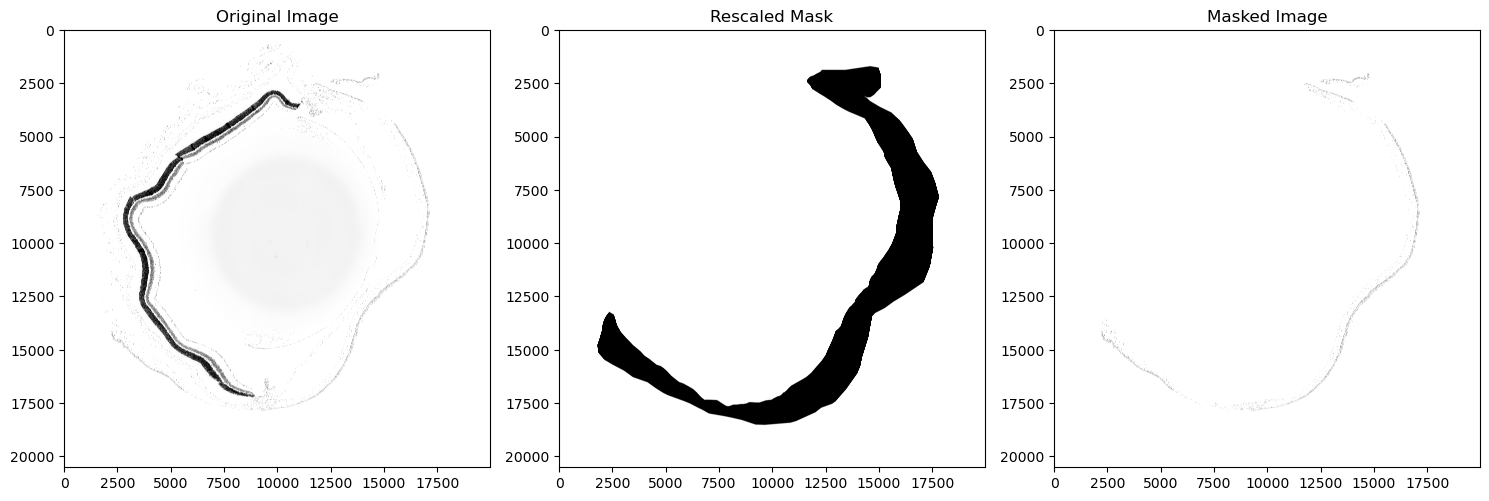

In [44]:
import cv2
import numpy as np

level = 0
pixelsize = scalefactors[level]

# 1. Rescale the coordinates
scaling_factor = pixelsize
x_coords_rescaled = x_coords / scaling_factor
y_coords_rescaled = y_coords / scaling_factor

# 2. Convert rescaled coordinates to points format for fillPoly
points_rescaled = np.column_stack((x_coords_rescaled, y_coords_rescaled)).astype(np.int32)
points_rescaled = points_rescaled.reshape((-1, 1, 2))

# 3. Create mask matching image shape
mask = np.zeros(image_chanel_0.shape, dtype=np.uint8)

# 4. Fill the polygon in white (255)
cv2.fillPoly(mask, [points_rescaled], color=255)

# 5. Apply mask to original image
mask_bool = mask > 0
masked_image_0 = np.zeros_like(image_chanel_0)
masked_image_0[mask_bool] = image_chanel_0[mask_bool]

# 6. Visualize to check the results
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(image_chanel_0, cmap='binary')
plt.title('Original Image')
plt.axis('scaled')

plt.subplot(132)
plt.imshow(mask, cmap='binary')
plt.title('Rescaled Mask')
plt.axis('scaled')

plt.subplot(133)
plt.imshow(masked_image_0, cmap='binary')
plt.title('Masked Image')
plt.axis('scaled')

plt.tight_layout()
plt.show()

In [45]:
image_chanel_2 = tifffile.imread(fullres_chanel_2, is_ome=False, level=level)


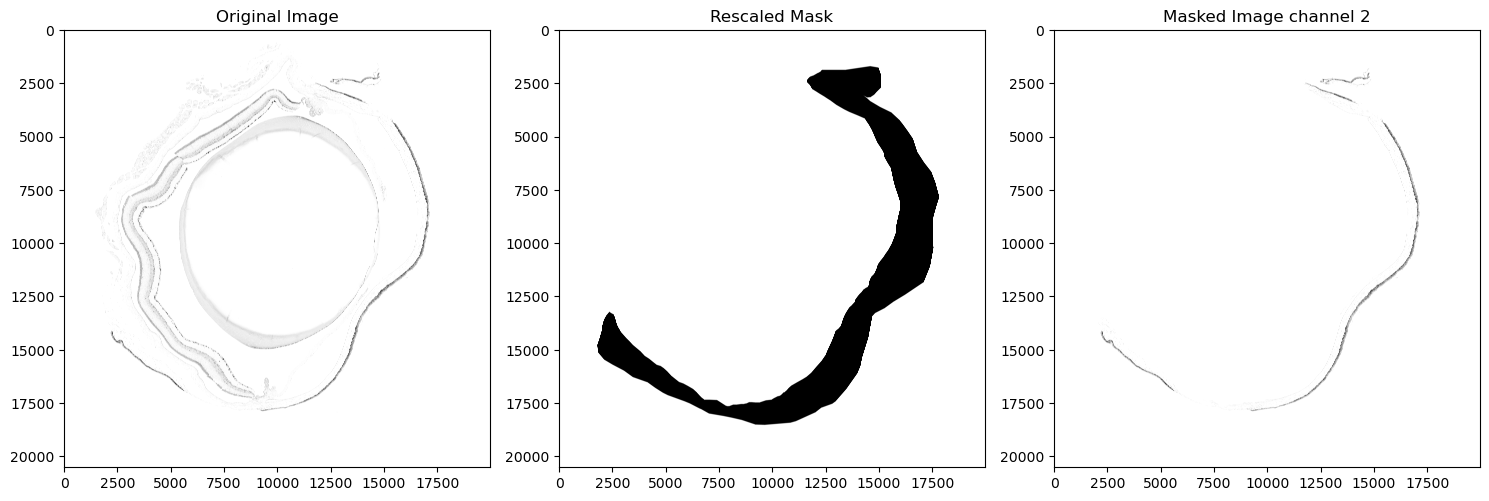

In [46]:
import cv2
import numpy as np

level = 0
pixelsize = scalefactors[level]

# 1. Rescale the coordinates
scaling_factor = pixelsize
x_coords_rescaled = x_coords / scaling_factor
y_coords_rescaled = y_coords / scaling_factor

# 2. Convert rescaled coordinates to points format for fillPoly
points_rescaled = np.column_stack((x_coords_rescaled, y_coords_rescaled)).astype(np.int32)
points_rescaled = points_rescaled.reshape((-1, 1, 2))

# 3. Create mask matching image shape
mask = np.zeros(image_chanel_0.shape, dtype=np.uint8)

# 4. Fill the polygon in white (255)
cv2.fillPoly(mask, [points_rescaled], color=255)

# 5. Apply mask to original image
mask_bool = mask > 0
masked_image_2 = np.zeros_like(image_chanel_2)
masked_image_2[mask_bool] = image_chanel_2[mask_bool]

# 6. Visualize to check the results
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(image_chanel_2, cmap='binary')
plt.title('Original Image')
plt.axis('scaled')

plt.subplot(132)
plt.imshow(mask, cmap='binary')
plt.title('Rescaled Mask')
plt.axis('scaled')

plt.subplot(133)
plt.imshow(masked_image_2, cmap='binary')
plt.title('Masked Image channel 2')
plt.axis('scaled')

plt.tight_layout()
plt.show()

In [47]:

def crop_polygon_to_overlapping_squares(polygon, square_size, overlap_size=40/0.2125):
    """
    Crops a polygon into overlapping square regions of a given size.

    Args:
        polygon (Polygon): The input polygon to crop.
        square_size (float): The base size of each square region (side length).
        overlap_size (float): The amount of overlap in um (default: 20).

    Returns:
        List[Polygon]: List of overlapping square polygons that fully contain the polygon.
    """
    # Get bounding box of the polygon
    minx, miny, maxx, maxy = polygon.bounds

    # Generate grid of overlapping squares
    squares = []
    for x in range(int(minx), int(maxx), square_size):
        for y in range(int(miny), int(maxy), square_size):
            # Create expanded square with overlap
            # First vertex (x, y) remains the same
            # Other vertices are expanded by overlap_size
            square = box(
                x,                          # minx (unchanged)
                y,                          # miny (unchanged)
                x + square_size + overlap_size,  # maxx (expanded)
                y + square_size + overlap_size   # maxy (expanded)
            )
            # Check if the square intersects the polygon
            if polygon.intersects(square):
                squares.append(square)
    
    return squares

In [48]:
# Combine X and Y into coordinate pairs
rescaled_polygon_roi = list(zip(x_coords_rescaled, y_coords_rescaled))

# Create a Polygon object
rescaled_polygon_roi = Polygon(rescaled_polygon_roi)
print(rescaled_polygon_roi)

POLYGON ((14595.435294117648 1745.2235294117647, 14939.670588235294 1802.5882352941178, 14939.670588235294 1802.5882352941178, 14982.729411764705 1816.9411764705883, 15068.752941176472 2046.4470588235295, 15111.811764705884 2204.235294117647, 15111.811764705884 2534.164705882353, 15083.10588235294 2763.6235294117646, 14896.658823529411 2950.1176470588234, 14781.882352941177 3079.2000000000003, 14609.788235294118 3193.9764705882353, 14452.000000000002 3208.2823529411767, 14208.141176470588 3079.2000000000003, 14308.564705882354 3136.564705882353, 14437.64705882353 3236.9882352941177, 14595.435294117648 3380.423529411765, 15054.44705882353 3652.9882352941177, 15585.129411764707 3911.152941176471, 15972.423529411764 4269.7411764705885, 16130.211764705884 4470.588235294118, 16359.717647058824 4786.117647058823, 16603.576470588236 5144.752941176471, 16804.376470588235 5761.505882352941, 17119.95294117647 6249.223529411765, 17464.188235294117 6693.882352941177, 17650.682352941178 7181.552941

square: POLYGON ((4811.235294117647 13037, 4811.235294117647 16048.235294117647, 1800 16048.235294117647, 1800 13037, 4811.235294117647 13037))
 x: array('d', [4811.235294117647, 4811.235294117647, 1800.0, 1800.0, 4811.235294117647]) 
 y: array('d', [13037.0, 16048.235294117647, 16048.235294117647, 13037.0, 13037.0])
square: POLYGON ((4811.235294117647 15860, 4811.235294117647 18871.235294117647, 1800 18871.235294117647, 1800 15860, 4811.235294117647 15860))
 x: array('d', [4811.235294117647, 4811.235294117647, 1800.0, 1800.0, 4811.235294117647]) 
 y: array('d', [15860.0, 18871.235294117647, 18871.235294117647, 15860.0, 15860.0])
square: POLYGON ((7634.235294117647 13037, 7634.235294117647 16048.235294117647, 4623 16048.235294117647, 4623 13037, 7634.235294117647 13037))
 x: array('d', [7634.235294117647, 7634.235294117647, 4623.0, 4623.0, 7634.235294117647]) 
 y: array('d', [13037.0, 16048.235294117647, 16048.235294117647, 13037.0, 13037.0])
square: POLYGON ((7634.235294117647 15860, 

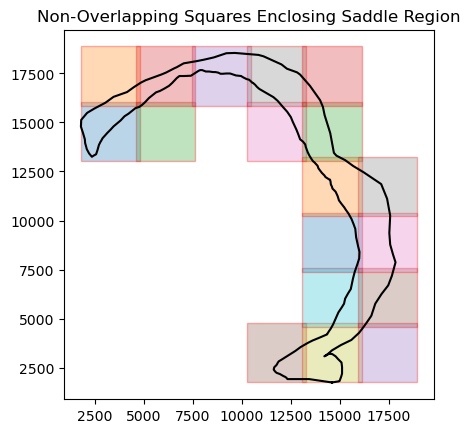

In [49]:
# Define square size
square_size = int(crop_size) # Adjust as necessary 


# Generate non-overlapping square regions
overlapping_squares = crop_polygon_to_overlapping_squares(rescaled_polygon_roi, square_size)

# Visualization
fig, ax = plt.subplots()
# Plot the original polygon
x, y = rescaled_polygon_roi.exterior.xy
ax.plot(x, y, 'k-', label="Saddle-shaped Polygon")  # Black for polygon

# Plot the square regions
for square in overlapping_squares:
    print("square:", square)
    x, y = square.exterior.xy
    print(" x:", x,"\n", "y:", y)
    ax.fill(x, y, edgecolor='red', alpha=0.3, label="Red Square")

# Add labels and legend
ax.set_title(f"Non-Overlapping Squares Enclosing Saddle Region")
ax.set_aspect('equal', 'box')
# ax.legend(loc="upper left")
plt.show()

In [50]:

# Define a function to crop the image based on a shapely Polygon
def crop_region(image, poly):
    """
    Crops the rectangular bounding box of a polygon from an image.

    Parameters:
        image (ndarray): The original image to crop.
        poly (Polygon): A shapely Polygon object defining the region.

    Returns:
        ndarray: The cropped image region.
    """
    # Get the bounding box of the polygon
    min_x, min_y, max_x, max_y = map(int, poly.bounds)
    
    # Crop the image using the bounding box
    cropped_image = image[min_y:max_y, min_x:max_x]
    
    return cropped_image


# Process and plot the square regions
for i, square in enumerate(overlapping_squares):
    print(f"Processing square {i + 1}:", square)
    
    # ch 0 Crop the region 
    cropped_image_sub = crop_region(masked_image_0, square)

    # ch2 Crop the region
    cropped_image_sub2 = crop_region(masked_image_2, square)

    cropped_image_sub_combined = np.stack((cropped_image_sub, cropped_image_sub2), axis=0)


    # Save the cropped image
    save_path = f"{ddir}\cropped_image\{sample_name}\cropped_square_com_{i + 1}.tif"
    tifffile.imwrite(save_path, cropped_image_sub_combined)
    print(f"Cropped image saved to {save_path}")
    

Processing square 1: POLYGON ((4811.235294117647 13037, 4811.235294117647 16048.235294117647, 1800 16048.235294117647, 1800 13037, 4811.235294117647 13037))
Cropped image saved to G:\Alexis_data\Project\SpatialOmics_cellpose\results\cropped_image\1792od\cropped_square_com_1.tif
Processing square 2: POLYGON ((4811.235294117647 15860, 4811.235294117647 18871.235294117647, 1800 18871.235294117647, 1800 15860, 4811.235294117647 15860))
Cropped image saved to G:\Alexis_data\Project\SpatialOmics_cellpose\results\cropped_image\1792od\cropped_square_com_2.tif
Processing square 3: POLYGON ((7634.235294117647 13037, 7634.235294117647 16048.235294117647, 4623 16048.235294117647, 4623 13037, 7634.235294117647 13037))
Cropped image saved to G:\Alexis_data\Project\SpatialOmics_cellpose\results\cropped_image\1792od\cropped_square_com_3.tif
Processing square 4: POLYGON ((7634.235294117647 15860, 7634.235294117647 18871.235294117647, 4623 18871.235294117647, 4623 15860, 7634.235294117647 15860))
Croppe